# Image classification

In [1]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Preprocessing

In [3]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

### Augmentation

In [4]:
import torchvision.transforms as transforms

mean_tensor = torch.tensor([0.5, 0.5, 0.5])
std_tensor = torch.tensor([0.5, 0.5, 0.5])

# mean_tensor = torch.tensor([0.5209, 0.4955, 0.4384])
# std_tensor = torch.tensor([0.2111, 0.2103, 0.2101])

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

### Datasets and sampling

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from data import sample_dataset

train_default_ds = ImageFolder(train_dir, transform=default_transform)
train_augmented_ds = ImageFolder(train_dir, transform=augmented_transform)
train_ds = ConcatDataset([train_default_ds, train_augmented_ds])

val_ds = ImageFolder(val_dir, transform=default_transform)

# downsample the dataset
sample_ratio = 1
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_default_ds.classes)
class_names = train_default_ds.classes

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

Number of training samples: 140818
Number of validation samples: 17602


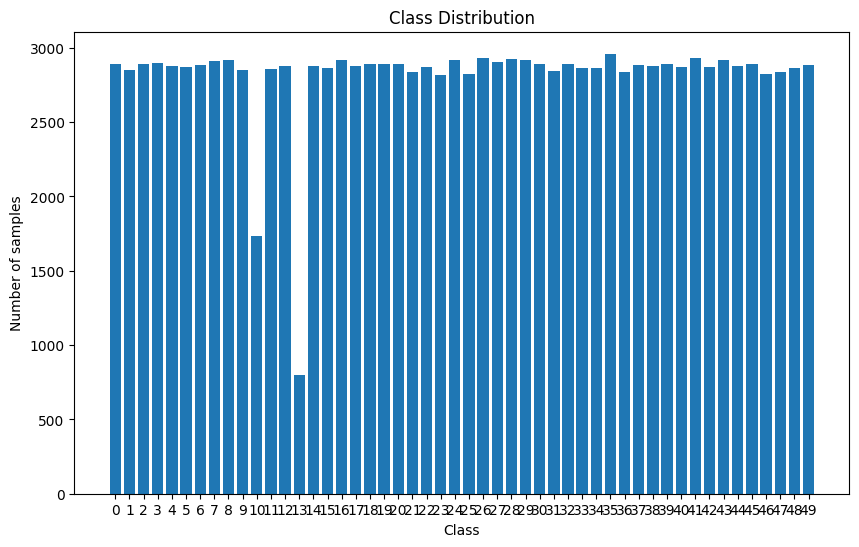

In [ ]:
from plots import plot_class_distribution

plot_class_distribution(sampled_train_ds)

#### Default dataset

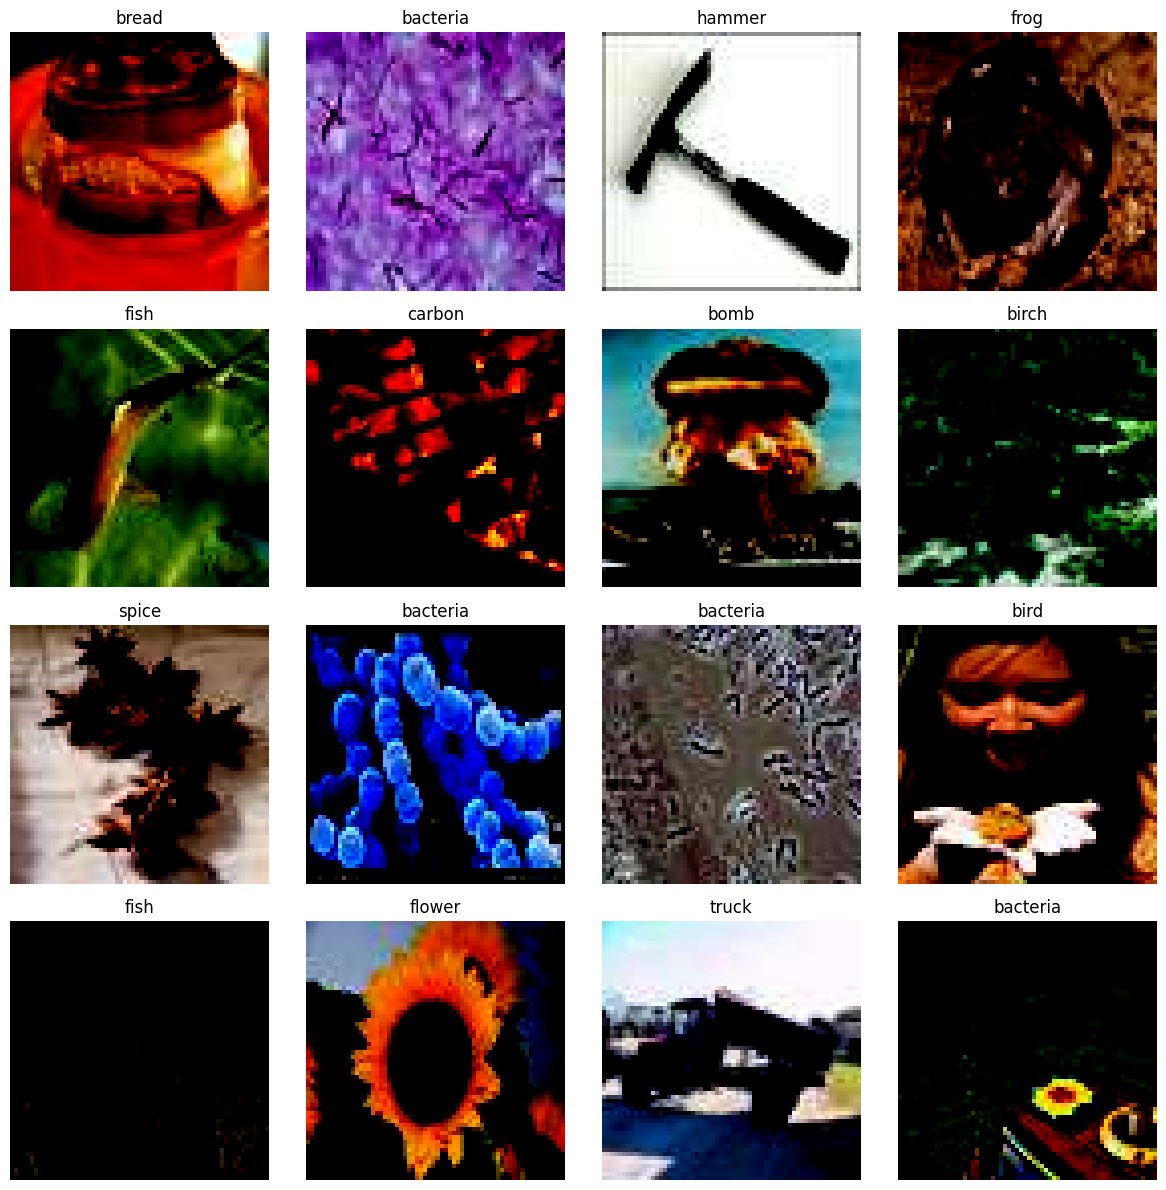

In [ ]:

from plots import preview

# plot default training dataset
preview(train_default_ds, n_samples=16, classes=class_names, seed=42)

#### Augmented dataset

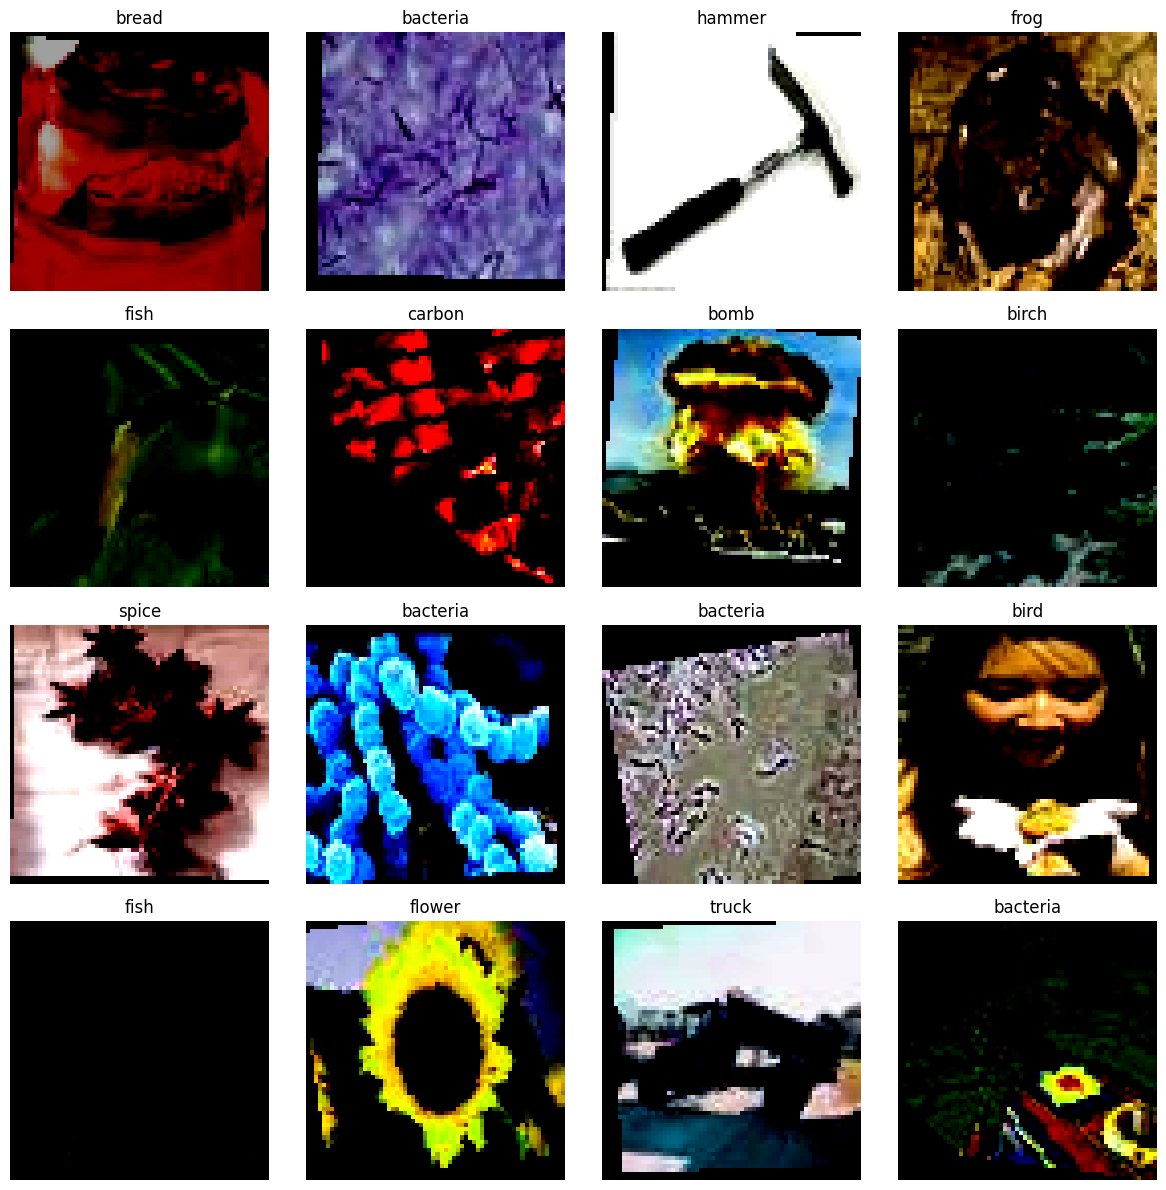

In [ ]:
# plot augmented training dataset
preview(train_augmented_ds, n_samples=16, classes=class_names, seed=42)

### Data loaders

In [19]:
batch_size = 256
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=False)

finetune_ds = ConcatDataset([sample_dataset(train_default_ds, 0.5, seed=random_state), train_augmented_ds])
finetune_dl = DataLoader(finetune_ds,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True,
                          generator=Generator().manual_seed(random_state))

## Training

In [9]:
from training import Trainer
import torch.optim as optim

### BasicModel

In [ ]:
from models import BasicNet

basicNet = BasicNet(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=50)

Epoch 1/50 (validation): 100%|██████████| 69/69 [04:51<00:00,  4.22s/it]


Epoch 1/50: Train Loss: 3.1975, Val Loss: 2.6314, Avg Class Accuracy: 0.2980


Epoch 2/50 (validation): 100%|██████████| 69/69 [03:41<00:00,  3.21s/it]


Epoch 2/50: Train Loss: 2.6930, Val Loss: 2.3056, Avg Class Accuracy: 0.3785


Epoch 3/50 (validation): 100%|██████████| 69/69 [03:46<00:00,  3.29s/it]


Epoch 3/50: Train Loss: 2.4777, Val Loss: 2.1555, Avg Class Accuracy: 0.4095


Epoch 4/50 (validation): 100%|██████████| 69/69 [04:18<00:00,  3.75s/it]


Epoch 4/50: Train Loss: 2.3423, Val Loss: 2.0635, Avg Class Accuracy: 0.4344


Epoch 5/50 (validation): 100%|██████████| 69/69 [01:12<00:00,  1.06s/it]


Epoch 5/50: Train Loss: 2.2412, Val Loss: 1.9764, Avg Class Accuracy: 0.4526


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 6/50: Train Loss: 2.1680, Val Loss: 1.9539, Avg Class Accuracy: 0.4627


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.82it/s]


Epoch 7/50: Train Loss: 2.1045, Val Loss: 1.8550, Avg Class Accuracy: 0.4872


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 8/50: Train Loss: 2.0559, Val Loss: 1.8631, Avg Class Accuracy: 0.4850


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.83it/s]


Epoch 9/50: Train Loss: 2.0099, Val Loss: 1.7911, Avg Class Accuracy: 0.5045


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.85it/s]


Epoch 10/50: Train Loss: 1.9668, Val Loss: 1.7395, Avg Class Accuracy: 0.5192


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 11/50: Train Loss: 1.9296, Val Loss: 1.7159, Avg Class Accuracy: 0.5231


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:23<00:00,  2.97it/s]


Epoch 12/50: Train Loss: 1.8968, Val Loss: 1.6782, Avg Class Accuracy: 0.5322


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 13/50: Train Loss: 1.8613, Val Loss: 1.6796, Avg Class Accuracy: 0.5343


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 14/50: Train Loss: 1.8287, Val Loss: 1.6300, Avg Class Accuracy: 0.5455


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.70it/s]


Epoch 15/50: Train Loss: 1.8080, Val Loss: 1.6446, Avg Class Accuracy: 0.5438


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.70it/s]


Epoch 16/50: Train Loss: 1.7817, Val Loss: 1.6105, Avg Class Accuracy: 0.5497


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 17/50: Train Loss: 1.7564, Val Loss: 1.5896, Avg Class Accuracy: 0.5605


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]


Epoch 18/50: Train Loss: 1.7390, Val Loss: 1.5692, Avg Class Accuracy: 0.5613


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]


Epoch 19/50: Train Loss: 1.7168, Val Loss: 1.5630, Avg Class Accuracy: 0.5650


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.16it/s]


Epoch 20/50: Train Loss: 1.6948, Val Loss: 1.5477, Avg Class Accuracy: 0.5677


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 21/50: Train Loss: 1.6796, Val Loss: 1.5438, Avg Class Accuracy: 0.5698


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 22/50: Train Loss: 1.6616, Val Loss: 1.5222, Avg Class Accuracy: 0.5737


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 23/50: Train Loss: 1.6412, Val Loss: 1.4954, Avg Class Accuracy: 0.5810


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 24/50: Train Loss: 1.6235, Val Loss: 1.5052, Avg Class Accuracy: 0.5771


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 25/50: Train Loss: 1.6128, Val Loss: 1.4841, Avg Class Accuracy: 0.5881


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 26/50: Train Loss: 1.5957, Val Loss: 1.4880, Avg Class Accuracy: 0.5865


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 27/50: Train Loss: 1.5816, Val Loss: 1.4717, Avg Class Accuracy: 0.5860


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 28/50: Train Loss: 1.5673, Val Loss: 1.4759, Avg Class Accuracy: 0.5870


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 29/50: Train Loss: 1.5549, Val Loss: 1.4822, Avg Class Accuracy: 0.5866


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 30/50: Train Loss: 1.5414, Val Loss: 1.4462, Avg Class Accuracy: 0.5928


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 31/50: Train Loss: 1.5294, Val Loss: 1.4426, Avg Class Accuracy: 0.5980


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 32/50: Train Loss: 1.5187, Val Loss: 1.4450, Avg Class Accuracy: 0.5967


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 33/50: Train Loss: 1.5063, Val Loss: 1.4363, Avg Class Accuracy: 0.5979


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 34/50: Train Loss: 1.4932, Val Loss: 1.4097, Avg Class Accuracy: 0.6042


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 35/50: Train Loss: 1.4823, Val Loss: 1.4245, Avg Class Accuracy: 0.6009


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:24<00:00,  2.82it/s]


Epoch 36/50: Train Loss: 1.4734, Val Loss: 1.3891, Avg Class Accuracy: 0.6103


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 37/50: Train Loss: 1.4627, Val Loss: 1.4298, Avg Class Accuracy: 0.6036


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]


Epoch 38/50: Train Loss: 1.4511, Val Loss: 1.3981, Avg Class Accuracy: 0.6077


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 39/50: Train Loss: 1.4402, Val Loss: 1.4015, Avg Class Accuracy: 0.6089


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 40/50: Train Loss: 1.4333, Val Loss: 1.3995, Avg Class Accuracy: 0.6105


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 41/50: Train Loss: 1.4269, Val Loss: 1.3966, Avg Class Accuracy: 0.6083


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 42/50: Train Loss: 1.4137, Val Loss: 1.3685, Avg Class Accuracy: 0.6148


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 43/50: Train Loss: 1.4070, Val Loss: 1.3773, Avg Class Accuracy: 0.6132


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 44/50: Train Loss: 1.3951, Val Loss: 1.3464, Avg Class Accuracy: 0.6213


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 45/50: Train Loss: 1.3900, Val Loss: 1.3517, Avg Class Accuracy: 0.6193


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 46/50: Train Loss: 1.3762, Val Loss: 1.3612, Avg Class Accuracy: 0.6155


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 47/50: Train Loss: 1.3679, Val Loss: 1.3599, Avg Class Accuracy: 0.6215


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 48/50: Train Loss: 1.3654, Val Loss: 1.3407, Avg Class Accuracy: 0.6229


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 49/50: Train Loss: 1.3560, Val Loss: 1.3394, Avg Class Accuracy: 0.6222


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.54it/s]

Epoch 50/50: Train Loss: 1.3465, Val Loss: 1.3286, Avg Class Accuracy: 0.6269


### Basic Model Using AvgPool

In [ ]:
from models import AVGPoolNet_Kernel5

avgPoolNet5 = AVGPoolNet_Kernel5(num_classes=num_classes)

optimizer = optim.Adam(avgPoolNet5.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(avgPoolNet5, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Epoch 1/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 1/20: Train Loss: 3.5519, Val Loss: 3.1893, Avg Class Accuracy: 0.1791


Epoch 2/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 2/20: Train Loss: 3.2039, Val Loss: 2.9163, Avg Class Accuracy: 0.2359


Epoch 3/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.00it/s]


Epoch 3/20: Train Loss: 3.0018, Val Loss: 2.7232, Avg Class Accuracy: 0.2865


Epoch 4/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 4/20: Train Loss: 2.8473, Val Loss: 2.6173, Avg Class Accuracy: 0.3054


Epoch 5/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 5/20: Train Loss: 2.7407, Val Loss: 2.5357, Avg Class Accuracy: 0.3214


Epoch 6/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 6/20: Train Loss: 2.6482, Val Loss: 2.4430, Avg Class Accuracy: 0.3424


Epoch 7/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 7/20: Train Loss: 2.5674, Val Loss: 2.3899, Avg Class Accuracy: 0.3511


Epoch 8/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]


Epoch 8/20: Train Loss: 2.4828, Val Loss: 2.4825, Avg Class Accuracy: 0.3355


Epoch 9/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 9/20: Train Loss: 2.4221, Val Loss: 2.3141, Avg Class Accuracy: 0.3703


Epoch 10/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 10/20: Train Loss: 2.3714, Val Loss: 2.2475, Avg Class Accuracy: 0.3917


Epoch 11/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 11/20: Train Loss: 2.3183, Val Loss: 2.2660, Avg Class Accuracy: 0.3872


Epoch 12/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]


Epoch 12/20: Train Loss: 2.2730, Val Loss: 2.1535, Avg Class Accuracy: 0.4097


Epoch 13/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 13/20: Train Loss: 2.2267, Val Loss: 2.1056, Avg Class Accuracy: 0.4186


Epoch 14/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]


Epoch 14/20: Train Loss: 2.1863, Val Loss: 2.0864, Avg Class Accuracy: 0.4259


Epoch 15/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]


Epoch 15/20: Train Loss: 2.1445, Val Loss: 2.1005, Avg Class Accuracy: 0.4210


Epoch 16/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]


Epoch 16/20: Train Loss: 2.1160, Val Loss: 2.0568, Avg Class Accuracy: 0.4305


Epoch 17/20 (training):  54%|█████▎    | 74/138 [00:28<00:24,  2.62it/s]


KeyboardInterrupt: 

In [ ]:
from models import AVGPoolNet_Kernel3

avgPoolNet3 = AVGPoolNet_Kernel3(num_classes=num_classes)

optimizer = optim.Adam(avgPoolNet3.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(avgPoolNet3, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Epoch 1/20 (validation): 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 1/20: Train Loss: 3.6056, Val Loss: 3.2587, Avg Class Accuracy: 0.1653


Epoch 2/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 2/20: Train Loss: 3.2894, Val Loss: 3.0086, Avg Class Accuracy: 0.2249


Epoch 3/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]


Epoch 3/20: Train Loss: 3.1105, Val Loss: 2.8311, Avg Class Accuracy: 0.2505


Epoch 4/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 4/20: Train Loss: 2.9690, Val Loss: 2.7241, Avg Class Accuracy: 0.2778


Epoch 5/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.00it/s]


Epoch 5/20: Train Loss: 2.8552, Val Loss: 2.5964, Avg Class Accuracy: 0.3081


Epoch 6/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 6/20: Train Loss: 2.7637, Val Loss: 2.5547, Avg Class Accuracy: 0.3171


Epoch 7/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 7/20: Train Loss: 2.6879, Val Loss: 2.4556, Avg Class Accuracy: 0.3433


Epoch 8/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 8/20: Train Loss: 2.6138, Val Loss: 2.3922, Avg Class Accuracy: 0.3509


Epoch 9/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 9/20: Train Loss: 2.5552, Val Loss: 2.3663, Avg Class Accuracy: 0.3565


Epoch 10/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]


Epoch 10/20: Train Loss: 2.5071, Val Loss: 2.2936, Avg Class Accuracy: 0.3762


Epoch 11/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 11/20: Train Loss: 2.4516, Val Loss: 2.2685, Avg Class Accuracy: 0.3804


Epoch 12/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]


Epoch 12/20: Train Loss: 2.4129, Val Loss: 2.2203, Avg Class Accuracy: 0.3916


Epoch 13/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.95it/s]


Epoch 13/20: Train Loss: 2.3655, Val Loss: 2.2525, Avg Class Accuracy: 0.3869


Epoch 14/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 14/20: Train Loss: 2.3395, Val Loss: 2.2128, Avg Class Accuracy: 0.3902


Epoch 15/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]


Epoch 15/20: Train Loss: 2.3060, Val Loss: 2.1868, Avg Class Accuracy: 0.4021


Epoch 16/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 16/20: Train Loss: 2.2720, Val Loss: 2.1091, Avg Class Accuracy: 0.4196


Epoch 17/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.90it/s]


Epoch 17/20: Train Loss: 2.2431, Val Loss: 2.1306, Avg Class Accuracy: 0.4175


Epoch 18/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 18/20: Train Loss: 2.2123, Val Loss: 2.1298, Avg Class Accuracy: 0.4178


Epoch 19/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 19/20: Train Loss: 2.1843, Val Loss: 2.0676, Avg Class Accuracy: 0.4377


Epoch 20/20 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

Epoch 20/20: Train Loss: 2.1691, Val Loss: 2.0930, Avg Class Accuracy: 0.4242


### No pooling

In [ ]:
from models import No_PoolNet

noPoolNet = No_PoolNet(num_classes=num_classes)

optimizer = optim.Adam(noPoolNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(noPoolNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

Epoch 1/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.34it/s]


Epoch 1/30: Train Loss: 3.6513, Val Loss: 3.3290, Avg Class Accuracy: 0.1511


Epoch 2/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.30it/s]


Epoch 2/30: Train Loss: 3.3556, Val Loss: 3.1075, Avg Class Accuracy: 0.1935


Epoch 3/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]


Epoch 3/30: Train Loss: 3.1828, Val Loss: 2.9245, Avg Class Accuracy: 0.2326


Epoch 4/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 4/30: Train Loss: 3.0407, Val Loss: 2.8046, Avg Class Accuracy: 0.2699


Epoch 5/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 5/30: Train Loss: 2.9307, Val Loss: 2.7194, Avg Class Accuracy: 0.2773


Epoch 6/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]


Epoch 6/30: Train Loss: 2.8368, Val Loss: 2.6641, Avg Class Accuracy: 0.2851


Epoch 7/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]


Epoch 7/30: Train Loss: 2.7550, Val Loss: 2.5602, Avg Class Accuracy: 0.3180


Epoch 8/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]


Epoch 8/30: Train Loss: 2.6783, Val Loss: 2.4966, Avg Class Accuracy: 0.3262


Epoch 9/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 9/30: Train Loss: 2.6033, Val Loss: 2.4735, Avg Class Accuracy: 0.3338


Epoch 10/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.12it/s]


Epoch 10/30: Train Loss: 2.5440, Val Loss: 2.3983, Avg Class Accuracy: 0.3416


Epoch 11/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 11/30: Train Loss: 2.4882, Val Loss: 2.4008, Avg Class Accuracy: 0.3532


Epoch 12/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 12/30: Train Loss: 2.4311, Val Loss: 2.3477, Avg Class Accuracy: 0.3573


Epoch 13/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.93it/s]


Epoch 13/30: Train Loss: 2.3787, Val Loss: 2.3147, Avg Class Accuracy: 0.3634


Epoch 14/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 14/30: Train Loss: 2.3369, Val Loss: 2.3540, Avg Class Accuracy: 0.3623


Epoch 15/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.88it/s]


Epoch 15/30: Train Loss: 2.2836, Val Loss: 2.2616, Avg Class Accuracy: 0.3809


Epoch 16/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]


Epoch 16/30: Train Loss: 2.2415, Val Loss: 2.2297, Avg Class Accuracy: 0.3918


Epoch 17/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.32it/s]


Epoch 17/30: Train Loss: 2.1964, Val Loss: 2.2054, Avg Class Accuracy: 0.3934


Epoch 18/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 18/30: Train Loss: 2.1603, Val Loss: 2.2154, Avg Class Accuracy: 0.3951


Epoch 19/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 19/30: Train Loss: 2.1262, Val Loss: 2.2037, Avg Class Accuracy: 0.3871


Epoch 20/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 20/30: Train Loss: 2.0866, Val Loss: 2.1822, Avg Class Accuracy: 0.3980


Epoch 21/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.39it/s]


Epoch 21/30: Train Loss: 2.0529, Val Loss: 2.1814, Avg Class Accuracy: 0.4049


Epoch 22/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]


Epoch 22/30: Train Loss: 2.0234, Val Loss: 2.1696, Avg Class Accuracy: 0.4034


Epoch 23/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]


Epoch 23/30: Train Loss: 1.9774, Val Loss: 2.1546, Avg Class Accuracy: 0.4051


Epoch 24/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.90it/s]


Epoch 24/30: Train Loss: 1.9570, Val Loss: 2.1302, Avg Class Accuracy: 0.4103


Epoch 25/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]


Epoch 25/30: Train Loss: 1.9268, Val Loss: 2.1574, Avg Class Accuracy: 0.4118


Epoch 26/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]


Epoch 26/30: Train Loss: 1.9028, Val Loss: 2.1213, Avg Class Accuracy: 0.4208


Epoch 27/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 27/30: Train Loss: 1.8780, Val Loss: 2.1505, Avg Class Accuracy: 0.4138


Epoch 28/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 28/30: Train Loss: 1.8506, Val Loss: 2.1272, Avg Class Accuracy: 0.4211


Epoch 29/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.20it/s]


Epoch 29/30: Train Loss: 1.8240, Val Loss: 2.1564, Avg Class Accuracy: 0.4191


Epoch 30/30 (validation): 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]

Epoch 30/30: Train Loss: 1.8038, Val Loss: 2.1300, Avg Class Accuracy: 0.4200


### Basic ResNet

In [ ]:
from models import BasicResNet

basicResNet = BasicResNet(num_classes=num_classes)

optimizer = optim.AdamW(basicResNet.to(device).parameters(), lr=1e-4, weight_decay=1e-4)

trainer = Trainer(basicResNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=50)

Epoch 1/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 1/50: Train Loss: 2.8239, Val Loss: 2.4377, Avg Class Accuracy: 0.3323


Epoch 2/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 2/50: Train Loss: 2.2333, Val Loss: 2.2033, Avg Class Accuracy: 0.4042


Epoch 3/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 3/50: Train Loss: 1.9612, Val Loss: 1.9874, Avg Class Accuracy: 0.4531


Epoch 4/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 4/50: Train Loss: 1.7686, Val Loss: 1.7886, Avg Class Accuracy: 0.5068


Epoch 5/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 5/50: Train Loss: 1.6128, Val Loss: 1.7283, Avg Class Accuracy: 0.5146


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 6/50: Train Loss: 1.4916, Val Loss: 1.5974, Avg Class Accuracy: 0.5515


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 7/50: Train Loss: 1.3862, Val Loss: 1.5549, Avg Class Accuracy: 0.5608


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 8/50: Train Loss: 1.2940, Val Loss: 1.5526, Avg Class Accuracy: 0.5663


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch 9/50: Train Loss: 1.2144, Val Loss: 1.5295, Avg Class Accuracy: 0.5766


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


Epoch 10/50: Train Loss: 1.1474, Val Loss: 1.4671, Avg Class Accuracy: 0.5932


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 11/50: Train Loss: 1.0796, Val Loss: 1.5496, Avg Class Accuracy: 0.5773


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 12/50: Train Loss: 1.0202, Val Loss: 1.4111, Avg Class Accuracy: 0.6100


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 13/50: Train Loss: 0.9655, Val Loss: 1.5639, Avg Class Accuracy: 0.5865


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 14/50: Train Loss: 0.9126, Val Loss: 1.4164, Avg Class Accuracy: 0.6180


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 15/50: Train Loss: 0.8664, Val Loss: 1.4535, Avg Class Accuracy: 0.6087


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 16/50: Train Loss: 0.8228, Val Loss: 1.4319, Avg Class Accuracy: 0.6168


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 17/50: Train Loss: 0.7864, Val Loss: 1.5126, Avg Class Accuracy: 0.6043


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 18/50: Train Loss: 0.7429, Val Loss: 1.3737, Avg Class Accuracy: 0.6274


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 19/50: Train Loss: 0.7041, Val Loss: 1.4430, Avg Class Accuracy: 0.6181


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 20/50: Train Loss: 0.6761, Val Loss: 1.4727, Avg Class Accuracy: 0.6206


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 21/50: Train Loss: 0.6541, Val Loss: 1.4759, Avg Class Accuracy: 0.6231


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 22/50: Train Loss: 0.6196, Val Loss: 1.5446, Avg Class Accuracy: 0.6250


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 23/50: Train Loss: 0.5927, Val Loss: 1.4938, Avg Class Accuracy: 0.6322


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 24/50: Train Loss: 0.5705, Val Loss: 1.4914, Avg Class Accuracy: 0.6292


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 25/50: Train Loss: 0.5483, Val Loss: 1.4775, Avg Class Accuracy: 0.6349


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 26/50: Train Loss: 0.5313, Val Loss: 1.5059, Avg Class Accuracy: 0.6340


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.66it/s]


Epoch 27/50: Train Loss: 0.5126, Val Loss: 1.4565, Avg Class Accuracy: 0.6397


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 28/50: Train Loss: 0.4967, Val Loss: 1.4610, Avg Class Accuracy: 0.6385


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 29/50: Train Loss: 0.4802, Val Loss: 1.4760, Avg Class Accuracy: 0.6409


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.76it/s]


Epoch 30/50: Train Loss: 0.4643, Val Loss: 1.4632, Avg Class Accuracy: 0.6415


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 31/50: Train Loss: 0.4568, Val Loss: 1.4802, Avg Class Accuracy: 0.6439


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 32/50: Train Loss: 0.4381, Val Loss: 1.5263, Avg Class Accuracy: 0.6407


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 33/50: Train Loss: 0.4255, Val Loss: 1.4726, Avg Class Accuracy: 0.6472


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 34/50: Train Loss: 0.4128, Val Loss: 1.5213, Avg Class Accuracy: 0.6498


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 35/50: Train Loss: 0.3994, Val Loss: 1.5918, Avg Class Accuracy: 0.6447


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 36/50: Train Loss: 0.3923, Val Loss: 1.5485, Avg Class Accuracy: 0.6440


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 37/50: Train Loss: 0.3788, Val Loss: 1.5804, Avg Class Accuracy: 0.6405


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 38/50: Train Loss: 0.3743, Val Loss: 1.5534, Avg Class Accuracy: 0.6469


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 39/50: Train Loss: 0.3599, Val Loss: 1.5862, Avg Class Accuracy: 0.6481


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 40/50: Train Loss: 0.3537, Val Loss: 1.5596, Avg Class Accuracy: 0.6423


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 41/50: Train Loss: 0.3458, Val Loss: 1.6147, Avg Class Accuracy: 0.6420


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.29it/s]


Epoch 42/50: Train Loss: 0.3357, Val Loss: 1.5304, Avg Class Accuracy: 0.6478


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 43/50: Train Loss: 0.3327, Val Loss: 1.5647, Avg Class Accuracy: 0.6562


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 44/50: Train Loss: 0.3208, Val Loss: 1.5456, Avg Class Accuracy: 0.6512


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Epoch 45/50: Train Loss: 0.3155, Val Loss: 1.5821, Avg Class Accuracy: 0.6459


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.30it/s]


Epoch 46/50: Train Loss: 0.3118, Val Loss: 1.6188, Avg Class Accuracy: 0.6486


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 47/50: Train Loss: 0.3028, Val Loss: 1.5328, Avg Class Accuracy: 0.6611


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 48/50: Train Loss: 0.2979, Val Loss: 1.6162, Avg Class Accuracy: 0.6487


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.14it/s]


Epoch 49/50: Train Loss: 0.2882, Val Loss: 1.5942, Avg Class Accuracy: 0.6505


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:22<00:00,  3.12it/s]

Epoch 50/50: Train Loss: 0.2801, Val Loss: 1.6138, Avg Class Accuracy: 0.6516


#### Base ResNet

In [13]:
from models import BasicResNet

lr = 1e-4
weight_decay = 1e-3
epochs = 50

pretrainedResNet = BasicResNet(num_classes=num_classes)

optimizer = optim.AdamW(pretrainedResNet.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

trainer = Trainer(pretrainedResNet, train_dl, val_dl,optimizer, scheduler=scheduler, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.30it/s]


Epoch 1/50: Train Loss: 2.8614, Val Loss: 2.4147, Avg Class Accuracy: 0.3351


Epoch 2/50 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.32it/s]


Epoch 2/50: Train Loss: 2.2776, Val Loss: 2.2111, Avg Class Accuracy: 0.3858


Epoch 3/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.27it/s]


Epoch 3/50: Train Loss: 2.0026, Val Loss: 1.9712, Avg Class Accuracy: 0.4556


Epoch 4/50 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.34it/s]


Epoch 4/50: Train Loss: 1.8114, Val Loss: 1.8380, Avg Class Accuracy: 0.4942


Epoch 5/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 5/50: Train Loss: 1.6583, Val Loss: 1.8106, Avg Class Accuracy: 0.5000


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 6/50: Train Loss: 1.5261, Val Loss: 1.7664, Avg Class Accuracy: 0.5131


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.18it/s]


Epoch 7/50: Train Loss: 1.4120, Val Loss: 1.7158, Avg Class Accuracy: 0.5298


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.24it/s]


Epoch 8/50: Train Loss: 1.3118, Val Loss: 1.6830, Avg Class Accuracy: 0.5415


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.22it/s]


Epoch 9/50: Train Loss: 1.2137, Val Loss: 1.6824, Avg Class Accuracy: 0.5423


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 10/50: Train Loss: 1.1326, Val Loss: 1.6905, Avg Class Accuracy: 0.5488


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 11/50: Train Loss: 1.0581, Val Loss: 1.6572, Avg Class Accuracy: 0.5565


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 12/50: Train Loss: 0.9864, Val Loss: 1.7076, Avg Class Accuracy: 0.5503


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.20it/s]


Epoch 13/50: Train Loss: 0.9253, Val Loss: 1.6993, Avg Class Accuracy: 0.5613


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 14/50: Train Loss: 0.8768, Val Loss: 1.6878, Avg Class Accuracy: 0.5652


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.17it/s]


Epoch 15/50: Train Loss: 0.8276, Val Loss: 1.6793, Avg Class Accuracy: 0.5727


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.29it/s]


Epoch 16/50: Train Loss: 0.7867, Val Loss: 1.7074, Avg Class Accuracy: 0.5686


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.22it/s]


Epoch 17/50: Train Loss: 0.7477, Val Loss: 1.7059, Avg Class Accuracy: 0.5696


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 18/50: Train Loss: 0.7118, Val Loss: 1.7088, Avg Class Accuracy: 0.5758


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 19/50: Train Loss: 0.6857, Val Loss: 1.7116, Avg Class Accuracy: 0.5796


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.20it/s]


Epoch 20/50: Train Loss: 0.6558, Val Loss: 1.7238, Avg Class Accuracy: 0.5749


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 21/50: Train Loss: 0.6365, Val Loss: 1.6990, Avg Class Accuracy: 0.5869


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.24it/s]


Epoch 22/50: Train Loss: 0.6201, Val Loss: 1.7060, Avg Class Accuracy: 0.5846


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 23/50: Train Loss: 0.5972, Val Loss: 1.7625, Avg Class Accuracy: 0.5794


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.14it/s]


Epoch 24/50: Train Loss: 0.5741, Val Loss: 1.7228, Avg Class Accuracy: 0.5840


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.16it/s]


Epoch 25/50: Train Loss: 0.5571, Val Loss: 1.7103, Avg Class Accuracy: 0.5920


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.22it/s]


Epoch 26/50: Train Loss: 0.5388, Val Loss: 1.7354, Avg Class Accuracy: 0.5895


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.16it/s]


Epoch 27/50: Train Loss: 0.5241, Val Loss: 1.7023, Avg Class Accuracy: 0.5942


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.27it/s]


Epoch 28/50: Train Loss: 0.5093, Val Loss: 1.7312, Avg Class Accuracy: 0.5931


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.28it/s]


Epoch 29/50: Train Loss: 0.4960, Val Loss: 1.7085, Avg Class Accuracy: 0.5945


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 30/50: Train Loss: 0.4819, Val Loss: 1.7185, Avg Class Accuracy: 0.5981


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.11it/s]


Epoch 31/50: Train Loss: 0.4714, Val Loss: 1.7257, Avg Class Accuracy: 0.5955


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.13it/s]


Epoch 32/50: Train Loss: 0.4596, Val Loss: 1.6956, Avg Class Accuracy: 0.6016


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:17<00:00,  4.06it/s]


Epoch 33/50: Train Loss: 0.4461, Val Loss: 1.7118, Avg Class Accuracy: 0.6000


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 34/50: Train Loss: 0.4349, Val Loss: 1.6904, Avg Class Accuracy: 0.6041


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 35/50: Train Loss: 0.4215, Val Loss: 1.6753, Avg Class Accuracy: 0.6072


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.13it/s]


Epoch 36/50: Train Loss: 0.4141, Val Loss: 1.6837, Avg Class Accuracy: 0.6054


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.11it/s]


Epoch 37/50: Train Loss: 0.4053, Val Loss: 1.6840, Avg Class Accuracy: 0.6060


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 38/50: Train Loss: 0.3987, Val Loss: 1.6767, Avg Class Accuracy: 0.6070


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 39/50: Train Loss: 0.3903, Val Loss: 1.6758, Avg Class Accuracy: 0.6067


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 40/50: Train Loss: 0.3837, Val Loss: 1.6812, Avg Class Accuracy: 0.6064


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 41/50: Train Loss: 0.3784, Val Loss: 1.6708, Avg Class Accuracy: 0.6092


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 42/50: Train Loss: 0.3712, Val Loss: 1.6599, Avg Class Accuracy: 0.6098


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.27it/s]


Epoch 43/50: Train Loss: 0.3680, Val Loss: 1.6636, Avg Class Accuracy: 0.6092


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 44/50: Train Loss: 0.3645, Val Loss: 1.6611, Avg Class Accuracy: 0.6102


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.25it/s]


Epoch 45/50: Train Loss: 0.3611, Val Loss: 1.6651, Avg Class Accuracy: 0.6113


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 46/50: Train Loss: 0.3548, Val Loss: 1.6633, Avg Class Accuracy: 0.6097


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 47/50: Train Loss: 0.3569, Val Loss: 1.6635, Avg Class Accuracy: 0.6103


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.29it/s]


Epoch 48/50: Train Loss: 0.3534, Val Loss: 1.6617, Avg Class Accuracy: 0.6111


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 49/50: Train Loss: 0.3525, Val Loss: 1.6594, Avg Class Accuracy: 0.6103


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.24it/s]

Epoch 50/50: Train Loss: 0.3501, Val Loss: 1.6611, Avg Class Accuracy: 0.6104


#### Finetuning

In [ ]:
from models import BasicResNet

lr = 1e-5
weight_decay = 1e-3
epochs = 10

fineTunedResNet = BasicResNet(num_classes=num_classes)
fineTunedResNet.load_state_dict(torch.load("./models/BasicResNet_best.pth"))

optimizer = optim.AdamW(fineTunedResNet.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

trainer = Trainer(fineTunedResNet, train_dl, val_dl, optimizer, scheduler=scheduler, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/10 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.35it/s]


Epoch 1/10: Train Loss: 2.1945, Val Loss: 2.4021, Avg Class Accuracy: 0.5381


Epoch 2/10 (training):   2%|▏         | 13/551 [00:03<02:19,  3.84it/s]


KeyboardInterrupt: 

### Four-block CNN

In [14]:
from models import FourBlockCNN

epochs = 50
lr = 1e-4
weight_decay = 1e-3

fourBlockCNN = FourBlockCNN(num_classes=num_classes)

optimizer = optim.Adam(fourBlockCNN.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

trainer = Trainer(fourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/50 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.94it/s]


Epoch 1/50: Train Loss: 3.3547, Val Loss: 3.4746, Avg Class Accuracy: 0.1251


Epoch 2/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.82it/s]


Epoch 2/50: Train Loss: 2.8859, Val Loss: 3.2544, Avg Class Accuracy: 0.1744


Epoch 3/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.80it/s]


Epoch 3/50: Train Loss: 2.5974, Val Loss: 2.8474, Avg Class Accuracy: 0.2500


Epoch 4/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.80it/s]


Epoch 4/50: Train Loss: 2.3765, Val Loss: 2.7263, Avg Class Accuracy: 0.2770


Epoch 5/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.79it/s]


Epoch 5/50: Train Loss: 2.2149, Val Loss: 2.7148, Avg Class Accuracy: 0.2829


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 6/50: Train Loss: 2.0740, Val Loss: 2.3367, Avg Class Accuracy: 0.3616


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Epoch 7/50: Train Loss: 1.9690, Val Loss: 2.1734, Avg Class Accuracy: 0.4010


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 8/50: Train Loss: 1.8728, Val Loss: 2.2262, Avg Class Accuracy: 0.3993


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 9/50: Train Loss: 1.7945, Val Loss: 2.0234, Avg Class Accuracy: 0.4414


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.61it/s]


Epoch 10/50: Train Loss: 1.7209, Val Loss: 1.8866, Avg Class Accuracy: 0.4860


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.64it/s]


Epoch 11/50: Train Loss: 1.6552, Val Loss: 2.0018, Avg Class Accuracy: 0.4536


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.63it/s]


Epoch 12/50: Train Loss: 1.5989, Val Loss: 1.8563, Avg Class Accuracy: 0.4852


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.63it/s]


Epoch 13/50: Train Loss: 1.5465, Val Loss: 1.8307, Avg Class Accuracy: 0.4929


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.61it/s]


Epoch 14/50: Train Loss: 1.4941, Val Loss: 1.7430, Avg Class Accuracy: 0.5210


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 15/50: Train Loss: 1.4501, Val Loss: 1.5602, Avg Class Accuracy: 0.5670


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.61it/s]


Epoch 16/50: Train Loss: 1.4121, Val Loss: 1.6713, Avg Class Accuracy: 0.5381


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 17/50: Train Loss: 1.3731, Val Loss: 1.5135, Avg Class Accuracy: 0.5821


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.60it/s]


Epoch 18/50: Train Loss: 1.3390, Val Loss: 1.5478, Avg Class Accuracy: 0.5701


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 19/50: Train Loss: 1.3069, Val Loss: 1.4722, Avg Class Accuracy: 0.5908


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 20/50: Train Loss: 1.2735, Val Loss: 1.5357, Avg Class Accuracy: 0.5750


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 21/50: Train Loss: 1.2468, Val Loss: 1.4524, Avg Class Accuracy: 0.5943


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 22/50: Train Loss: 1.2157, Val Loss: 1.3776, Avg Class Accuracy: 0.6137


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch 23/50: Train Loss: 1.1880, Val Loss: 1.4575, Avg Class Accuracy: 0.6004


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 24/50: Train Loss: 1.1603, Val Loss: 1.4478, Avg Class Accuracy: 0.6009


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 25/50: Train Loss: 1.1399, Val Loss: 1.4318, Avg Class Accuracy: 0.6064


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 26/50: Train Loss: 1.1173, Val Loss: 1.3780, Avg Class Accuracy: 0.6181


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 27/50: Train Loss: 1.0967, Val Loss: 1.3692, Avg Class Accuracy: 0.6184


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch 28/50: Train Loss: 1.0734, Val Loss: 1.3605, Avg Class Accuracy: 0.6250


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 29/50: Train Loss: 1.0537, Val Loss: 1.3339, Avg Class Accuracy: 0.6304


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 30/50: Train Loss: 1.0357, Val Loss: 1.3468, Avg Class Accuracy: 0.6269


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 31/50: Train Loss: 1.0149, Val Loss: 1.2751, Avg Class Accuracy: 0.6459


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch 32/50: Train Loss: 1.0005, Val Loss: 1.3039, Avg Class Accuracy: 0.6393


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch 33/50: Train Loss: 0.9747, Val Loss: 1.3577, Avg Class Accuracy: 0.6271


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 34/50: Train Loss: 0.9645, Val Loss: 1.2894, Avg Class Accuracy: 0.6447


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 35/50: Train Loss: 0.9473, Val Loss: 1.3243, Avg Class Accuracy: 0.6338


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 36/50: Train Loss: 0.9329, Val Loss: 1.4098, Avg Class Accuracy: 0.6147


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 37/50: Train Loss: 0.9162, Val Loss: 1.2929, Avg Class Accuracy: 0.6459


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch 38/50: Train Loss: 0.9005, Val Loss: 1.2198, Avg Class Accuracy: 0.6643


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 39/50: Train Loss: 0.8859, Val Loss: 1.2849, Avg Class Accuracy: 0.6486


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch 40/50: Train Loss: 0.8738, Val Loss: 1.3259, Avg Class Accuracy: 0.6417


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch 41/50: Train Loss: 0.8603, Val Loss: 1.2907, Avg Class Accuracy: 0.6474


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 42/50: Train Loss: 0.8452, Val Loss: 1.2787, Avg Class Accuracy: 0.6556


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch 43/50: Train Loss: 0.8377, Val Loss: 1.3209, Avg Class Accuracy: 0.6464


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch 44/50: Train Loss: 0.8263, Val Loss: 1.2282, Avg Class Accuracy: 0.6636


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 45/50: Train Loss: 0.8114, Val Loss: 1.2937, Avg Class Accuracy: 0.6479


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 46/50: Train Loss: 0.8022, Val Loss: 1.2591, Avg Class Accuracy: 0.6638


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 47/50: Train Loss: 0.7948, Val Loss: 1.2627, Avg Class Accuracy: 0.6606


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 48/50: Train Loss: 0.7814, Val Loss: 1.2561, Avg Class Accuracy: 0.6589


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 49/50: Train Loss: 0.7729, Val Loss: 1.2780, Avg Class Accuracy: 0.6576


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.46it/s]

Epoch 50/50: Train Loss: 0.7614, Val Loss: 1.2005, Avg Class Accuracy: 0.6779


#### Finetuning

In [ ]:
epochs = 10
lr = 1e-5
weight_decay = 1e-3

fineTunedFourBlockCNN = FourBlockCNN(num_classes=num_classes)
fineTunedFourBlockCNN.load_state_dict(torch.load("./models/FourBlockCNN_best.pth"))

optimizer = optim.Adam(fineTunedFourBlockCNN.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

trainer = Trainer(fineTunedFourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/10 (validation): 100%|██████████| 69/69 [00:23<00:00,  2.96it/s]


Epoch 1/10: Train Loss: 0.6295, Val Loss: 1.1402, Avg Class Accuracy: 0.6894


Epoch 2/10 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch 2/10: Train Loss: 0.5926, Val Loss: 1.1389, Avg Class Accuracy: 0.6940


Epoch 3/10 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 3/10: Train Loss: 0.5772, Val Loss: 1.1309, Avg Class Accuracy: 0.6934


Epoch 4/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch 4/10: Train Loss: 0.5711, Val Loss: 1.1470, Avg Class Accuracy: 0.6924


Epoch 5/10 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.26it/s]


Epoch 5/10: Train Loss: 0.5590, Val Loss: 1.1454, Avg Class Accuracy: 0.6899


Epoch 6/10 (validation): 100%|██████████| 69/69 [00:22<00:00,  3.06it/s]


Epoch 6/10: Train Loss: 0.5525, Val Loss: 1.1412, Avg Class Accuracy: 0.6949


Epoch 7/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.30it/s]


Epoch 7/10: Train Loss: 0.5489, Val Loss: 1.1544, Avg Class Accuracy: 0.6903


Epoch 8/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch 8/10: Train Loss: 0.5458, Val Loss: 1.1482, Avg Class Accuracy: 0.6919


Epoch 9/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.32it/s]


Epoch 9/10: Train Loss: 0.5392, Val Loss: 1.1472, Avg Class Accuracy: 0.6934


Epoch 10/10 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.14it/s]

Epoch 10/10: Train Loss: 0.5343, Val Loss: 1.1577, Avg Class Accuracy: 0.6915


In [20]:
epochs = 10
lr = 1e-6
weight_decay = 1e-3

fineTunedFourBlockCNN = FourBlockCNN(num_classes=num_classes)
fineTunedFourBlockCNN.load_state_dict(torch.load("./models/FourBlockCNN_best.pth"))

optimizer = optim.Adam(fineTunedFourBlockCNN.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-8)

trainer = Trainer(fineTunedFourBlockCNN, finetune_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/10 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.25it/s]


Epoch 1/10: Train Loss: 0.5881, Val Loss: 1.1494, Avg Class Accuracy: 0.6931


Epoch 2/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.35it/s]


Epoch 2/10: Train Loss: 0.5859, Val Loss: 1.1432, Avg Class Accuracy: 0.6929


Epoch 3/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.30it/s]


Epoch 3/10: Train Loss: 0.5874, Val Loss: 1.1444, Avg Class Accuracy: 0.6939


Epoch 4/10 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.24it/s]


Epoch 4/10: Train Loss: 0.5829, Val Loss: 1.1505, Avg Class Accuracy: 0.6926


Epoch 5/10 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.27it/s]


Epoch 5/10: Train Loss: 0.5834, Val Loss: 1.1501, Avg Class Accuracy: 0.6936


Epoch 6/10 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.25it/s]


Epoch 6/10: Train Loss: 0.5783, Val Loss: 1.1425, Avg Class Accuracy: 0.6947


Epoch 7/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.29it/s]


Epoch 7/10: Train Loss: 0.5797, Val Loss: 1.1415, Avg Class Accuracy: 0.6944


Epoch 8/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.31it/s]


Epoch 8/10: Train Loss: 0.5769, Val Loss: 1.1415, Avg Class Accuracy: 0.6939


Epoch 9/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.31it/s]


Epoch 9/10: Train Loss: 0.5771, Val Loss: 1.1413, Avg Class Accuracy: 0.6942


Epoch 10/10 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.36it/s]

Epoch 10/10: Train Loss: 0.5783, Val Loss: 1.1493, Avg Class Accuracy: 0.6928


## Save results

In [ ]:
evaluation_model = FourBlockCNN(num_classes=num_classes)
evaluation_model.load_state_dict(torch.load("./models/FourBlockCNN_best.pth"))

<All keys matched successfully>

In [25]:
from evaluation import save_results

test_dir = './data/test_all'

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

save_results(evaluation_model, test_dir, test_transform, device=device)

Processing images: 100%|██████████| 10000/10000 [00:39<00:00, 250.06it/s]

Saved 10000 predictions to pred.csv
